In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
# Gerekli kütüphane
import pandas as pd

# Dosya yolunu tanımlayalım
dosya_yolu = "/content/drive/MyDrive/veri_analiz/OnlineRetail.csv"

# Veriyi oku (encoding önemli!)
df = pd.read_csv(dosya_yolu, encoding="ISO-8859-1")

# İlk 5 satırı görüntüle
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [3]:
# Veri setinin genel bilgilerine bakalım
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
# Eksik veri var mı kontrol edelim
df.isnull().sum()


,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


### 📌 Eksik Veri Analizi

Veri setinde özellikle iki sütunda eksik veri olduğu görülmektedir:

- `Description`: 1.454 satırda ürün açıklaması eksiktir. Bu muhtemelen iade edilmiş, iptal edilmiş ya da sistemden hatalı girilmiş faturalardan kaynaklanıyor olabilir.
- `CustomerID`: 135.080 satırda müşteri ID'si eksik. Bu da çoğunlukla **anonim alışverişler** (örneğin kayıtsız kullanıcılar, misafir satışlar) olabilir.

💡 Karar:
- `Description` eksik olanları analiz dışı bırakmak mantıklı olabilir.
- `CustomerID` eksik olanlar için müşteri segmentasyonu yapılamaz, ancak satış analizi yapılabilir.



In [6]:
# Açıklama bilgisi (ürün ismi) eksik olanları silelim
df = df[df['Description'].notnull()]


In [7]:
# CustomerID eksik olan satırları şimdilik etiketleyelim
df['CustomerID'].fillna('Bilinmiyor', inplace=True)


<ipython-input-7-16fe2794afdb>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['CustomerID'].fillna('Bilinmiyor', inplace=True)
<ipython-input-7-16fe2794afdb>:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Bilinmiyor' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df['CustomerID'].fillna('Bilinmiyor', inplace=True)


In [8]:
# Temizlik sonrası eksik veri kalmış mı tekrar kontrol edelim
df.isnull().sum()


,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0


In [9]:
# Sütun veri türlerine bakalım
df.dtypes


,0
InvoiceNo,object
StockCode,object
Description,object
Quantity,int64
InvoiceDate,object
UnitPrice,float64
CustomerID,object
Country,object


In [10]:
# InvoiceDate sütununu datetime formatına çevir
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


In [11]:
# Yıl ve ay sütunlarını oluşturalım
df['Yil'] = df['InvoiceDate'].dt.year
df['Ay'] = df['InvoiceDate'].dt.month


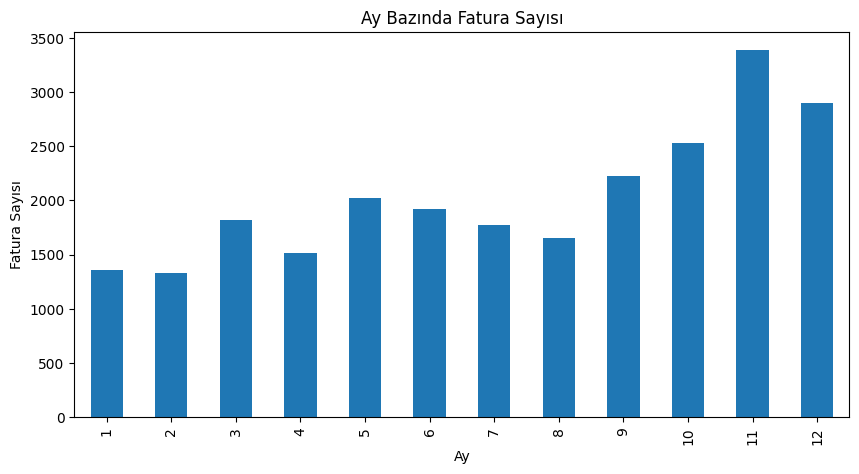

In [12]:
import matplotlib.pyplot as plt

# Ay bazlı fatura sayısını görselleştir
df.groupby('Ay')['InvoiceNo'].nunique().plot(kind='bar', figsize=(10,5), title='Ay Bazında Fatura Sayısı')
plt.xlabel('Ay')
plt.ylabel('Fatura Sayısı')
plt.show()


### 📌 Ay Bazlı Satış Yoğunluğu Yorumu

Grafikte görüldüğü üzere satışlar Kasım ayında zirve yapmıştır. Bu durum büyük ihtimalle:
- **Yıl sonu alışverişleri**
- **Black Friday / Cyber Monday** gibi kampanyalar
- Tatil dönemine hazırlık gibi etkenlerden kaynaklanmaktadır.

Bununla birlikte Eylül ve Ekim aylarında da ciddi bir artış gözlemleniyor.  
Ocak ve Şubat aylarında ise satışların düşük olduğu görülmektedir, bu da tipik bir sezon geçişi etkisi olabilir.


In [13]:
!pip install -q pandasql
import pandasql as psql


  Preparing metadata (setup.py) ... done


In [14]:
query = """
SELECT Country, COUNT(*) as SatisSayisi
FROM df
GROUP BY Country
ORDER BY SatisSayisi DESC
"""
psql.sqldf(query, locals())


,Country,SatisSayisi
0,United Kingdom,494024
1,Germany,9495
2,France,8557
3,EIRE,8196
4,Spain,2533
5,Netherlands,2371
6,Belgium,2069
7,Switzerland,2002
8,Portugal,1519
9,Australia,1259


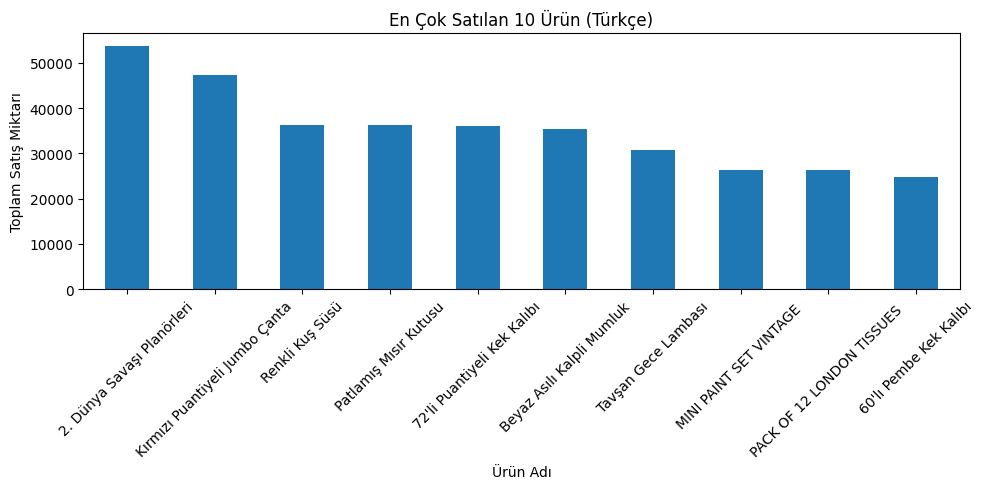

In [17]:
urun_cevir = {
    'WORLD WAR 2 GLIDERS ASSTD DESIGNS': '2. Dünya Savaşı Planörleri',
    'JUMBO BAG RED RETROSPOT': 'Kırmızı Puantiyeli Jumbo Çanta',
    'ASSORTED COLOUR BIRD ORNAMENT': 'Renkli Kuş Süsü',
    'POPCORN HOLDER': 'Patlamış Mısır Kutusu',
    'PACK OF 72 RETROSPOT CAKE CASES': '72\'li Puantiyeli Kek Kalıbı',
    'WHITE HANGING HEART T-LIGHT HOLDER': 'Beyaz Asılı Kalpli Mumluk',
    'RABBIT NIGHT LIGHT': 'Tavşan Gece Lambası',
    'MINI PAINT SET VINTAGE': 'Mini Boya Seti (Vintage)',
    'PACK OF 12 LONDON TISSUES': '12\'li Londra Temalı Mendil',
    'PACK OF 60 PINK PAISLEY CAKE CASES': '60\'lı Pembe Kek Kalıbı'
}
en_cok_satilan_urunler = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
en_cok_satilan_urunler.index = en_cok_satilan_urunler.index.map(lambda x: urun_cevir.get(x, x))
en_cok_satilan_urunler.plot(kind='bar', figsize=(10,5), title='En Çok Satılan 10 Ürün (Türkçe)')
plt.xlabel('Ürün Adı')
plt.ylabel('Toplam Satış Miktarı')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 📌 En Çok Satılan Ürünler Yorumu

Grafikte görüldüğü üzere en çok satılan ürünler, genel olarak **hediyelik eşya**, **dekoratif ürünler** ve **kek kalıbı gibi pratik ev malzemeleri** kategorisinde yoğunlaşmaktadır.

**"2. Dünya Savaşı Planörleri"** ve **"Kırmızı Puantiyeli Jumbo Çanta"** gibi düşük maliyetli ve dikkat çekici ürünlerin öne çıkması, tüketici davranışlarının genellikle uygun fiyatlı ve görsel olarak ilgi çekici ürünlere yöneldiğini göstermektedir.

Bu analiz;
- Stok planlaması,
- Yıl sonu kampanyaları,
- Promosyon ürün seçimi  
gibi ticari kararlar için kritik bir yol gösterici olabilir.

Ayrıca, bu ürünlerin sık tercih edilmesi **hedef müşteri kitlesinin alışveriş amacıyla mağazaya girdiğini değil, göz gezdirme sırasında uygun bulduğu ürünleri sepete eklediğini** düşündürmektedir.


In [18]:
# Yeni sütun: Toplam Satış (Ciro)
df['Ciro'] = df['Quantity'] * df['UnitPrice']

# İlk 5 satıra bakalım
df[['InvoiceNo', 'Quantity', 'UnitPrice', 'Ciro']].head()


,InvoiceNo,Quantity,UnitPrice,Ciro
0,536365,6,2.55,15.30
1,536365,6,3.39,20.34
2,536365,8,2.75,22.00
3,536365,6,3.39,20.34
4,536365,6,3.39,20.34


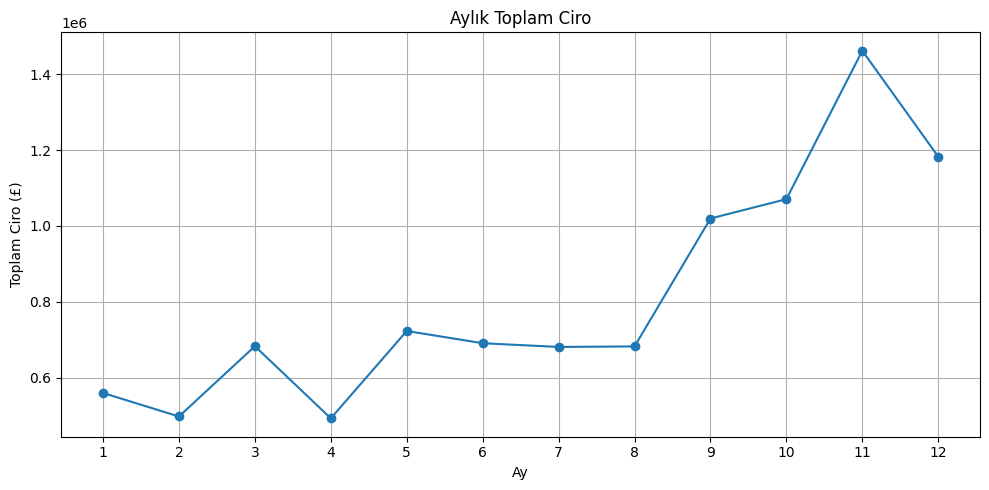

In [19]:
# Aylık toplam ciroyu hesapla
aylik_ciro = df.groupby('Ay')['Ciro'].sum()

# Görselleştirme
aylik_ciro.plot(kind='line', marker='o', figsize=(10,5), title='Aylık Toplam Ciro')
plt.xlabel('Ay')
plt.ylabel('Toplam Ciro (£)')
plt.grid(True)
plt.xticks(range(1,13))
plt.tight_layout()
plt.show()


### 📌 Aylık Ciro Trend Yorumu

Grafikte ay bazında toplam satış gelirleri görülmektedir.  
Kasım ayında ciroda belirgin bir artış yaşanmış, bu da muhtemelen:
- Black Friday ve yıl sonu alışverişi,
- Hediye sezonu hazırlıkları,
- Sezonluk indirim kampanyaları  
gibi faktörlerin etkisidir.

Yaz aylarında (Haziran–Temmuz–Ağustos) ciro düşüklüğü dikkat çekicidir.  
Bu, insanların tatilde olması, alışveriş motivasyonunun düşük olması gibi sezon etkilerini işaret ediyor olabilir.


In [20]:
query = """
SELECT Country, COUNT(*) AS SatisAdedi
FROM df
GROUP BY Country
ORDER BY SatisAdedi DESC
LIMIT 10
"""
psql.sqldf(query, locals())


,Country,SatisAdedi
0,United Kingdom,494024
1,Germany,9495
2,France,8557
3,EIRE,8196
4,Spain,2533
5,Netherlands,2371
6,Belgium,2069
7,Switzerland,2002
8,Portugal,1519
9,Australia,1259


### 📌 Ülke Bazlı Satış Analizi Yorumu

SQL sorgusu ile satış adetlerini ülkelere göre incelediğimizde:

- **United Kingdom (İngiltere)** açık ara farkla en fazla satış yapılan ülke. Bu, işletmenin İngiltere merkezli olduğunu ve e-ticaret faaliyetlerinin ağırlıklı olarak yerel pazarda yoğunlaştığını gösteriyor.
- Diğer ülkeler (Almanya, Fransa, İrlanda) çok daha düşük oranda satış yapmış. Bu da uluslararası satışların sınırlı olduğunu veya pazar payının düşük kaldığını gösterir.

💡 Stratejik öneri:
İngiltere dışındaki ülkelerde kampanya, lokal iş ortaklıkları veya çok dilli web sitesi gibi yöntemlerle büyüme sağlanabilir.


In [21]:
query = """
SELECT Description, MAX(UnitPrice) AS EnYuksekFiyat
FROM df
GROUP BY Description
ORDER BY EnYuksekFiyat DESC
LIMIT 10
"""
psql.sqldf(query, locals())


,Description,EnYuksekFiyat
0,Manual,38970.00
1,AMAZON FEE,17836.46
2,Adjust bad debt,11062.06
3,POSTAGE,8142.75
4,DOTCOM POSTAGE,4505.17
5,Discount,1867.86
6,CRUK Commission,1100.44
7,Bank Charges,1050.15
8,PICNIC BASKET WICKER 60 PIECES,649.50
9,SAMPLES,570.00


### 📌 En Pahalı Ürünler Analizi

SQL sorgusuna göre, en yüksek birim fiyatlı ürünler genellikle ürün değil, **hizmet veya işlem bedelleri** gibi görünüyor:

- `Manual`, `Adjust bad debt`, `Bank Charges`, `POSTAGE`, `Discount`, `CRUK Commission` gibi açıklamalar ürün değil; manuel işlem, posta masrafı veya dış kaynaklı ücretleri gösteriyor.
- Gerçek ürün olarak yalnızca `PICNIC BASKET WICKER 60 PIECES` dikkat çekiyor (649.50 £), bu da lüks segmentte bir ürün olabilir.

💡 Yorum:
Bu sonuç bize veri setinin yalnızca fiziksel ürünlerden değil, muhasebesel işlemlerden oluştuğunu da gösteriyor.  



In [22]:
# İade edilen işlemler
iadeler = df[df['Quantity'] < 0]

# En çok iade edilen ürünler
iadeler.groupby('Description')['Quantity'].sum().sort_values().head(10)


,Quantity
Description,
"PAPER CRAFT , LITTLE BIRDIE",-80995
MEDIUM CERAMIC TOP STORAGE JAR,-74494
printing smudges/thrown away,-19200
"Unsaleable, destroyed.",-15644
check,-13247
?,-9496
ROTATING SILVER ANGELS T-LIGHT HLDR,-9376
Printing smudges/thrown away,-9058
Damaged,-7540


### ♻️ En Çok İade Edilen Ürünler Yorumu

İade edilen ürünler arasında öne çıkanlar:

- `PAPER CRAFT, LITTLE BIRDIE`: -80.000 adetten fazla iade edilmiş
- `MEDIUM CERAMIC TOP STORAGE JAR`: Yine 70.000’in üzerinde iade

Bazı açıklamalar ise dikkat çekici:
- `printing smudges/thrown away`, `Unsaleable, destroyed`, `Damaged`, `?`, `check`

Bu ifadeler, ürünlerin **kalite kontrol sürecinde sorun yaşandığını**, hatta **doğrudan çöpe atıldığını** gösteriyor.

💡 Bu durum:
- Stok/maliyet yönetimini bozar
- Kârı azaltır
- Müşteri memnuniyetini düşürür

🛠️ Öneri:
İade gerekçelerine göre **ürün kalite kontrol süreçleri** yeniden gözden geçirilmeli, bu ürünler için tedarikçi/üretim kaynaklı önlemler alınmalı.


In [23]:
query = """
SELECT Country, ROUND(SUM(Quantity * UnitPrice), 2) AS ToplamCiro
FROM df
GROUP BY Country
ORDER BY ToplamCiro DESC
LIMIT 10
"""
psql.sqldf(query, locals())


,Country,ToplamCiro
0,United Kingdom,8187806.36
1,Netherlands,284661.54
2,EIRE,263276.82
3,Germany,221698.21
4,France,197403.90
5,Australia,137077.27
6,Switzerland,56385.35
7,Spain,54774.58
8,Belgium,40910.96
9,Sweden,36595.91


### 🌍 Ülke Bazlı Toplam Ciro Yorumu

En çok gelir getiren ülke açık ara farkla **United Kingdom (İngiltere)** – toplam 8.1 milyon £.  
Bu, satışların büyük kısmının yerel pazardan geldiğini bir kez daha doğruluyor.

Diğer ülkeler:

- **Hollanda**, **İrlanda**, **Almanya**, **Fransa** gibi Avrupa ülkeleri dikkat çekiyor.
- Ancak bu ülkelerdeki cirolar İngiltere'nin çok gerisinde.

💡 Yorum:
Bu analiz bize hem **pazarın merkezini** (İngiltere) hem de **büyüme potansiyeli olan pazarlara** (Hollanda, Almanya vb.) dair ipucu veriyor.

🚀 Tavsiye:
Uluslararası e-ticaret hedefleniyorsa, bu ülkelere özel reklam, lokal kampanya, dil desteği gibi yatırımlar yapılabilir.


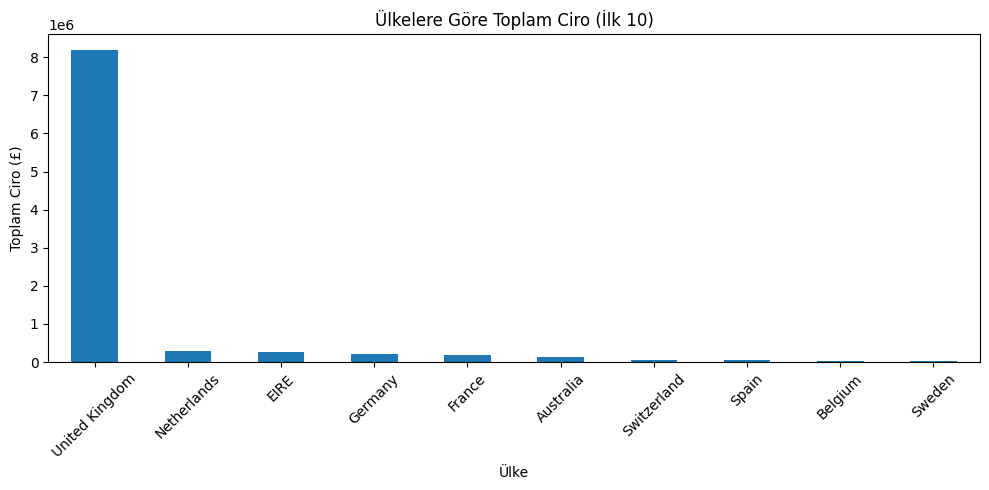

In [24]:
# Ülkelere göre toplam ciroyu Pandas ile hesapla
ulke_ciro = df.groupby('Country')['Ciro'].sum().sort_values(ascending=False).head(10)

# Grafik
ulke_ciro.plot(kind='bar', figsize=(10,5), title='Ülkelere Göre Toplam Ciro (İlk 10)')
plt.xlabel('Ülke')
plt.ylabel('Toplam Ciro (£)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
